# 実習7-1
### CBOWをkerasで実装してみる
https://github.com/nzw0301/keras-examples/blob/master/CBoW.ipynb
を参照しました。

In [1]:
import numpy as np
np.random.seed(13)

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [2]:
# 学習データの準備1

#get_fileでalice.txtをダウンロード (get_fileについては-->https://keras.io/ja/utils/)
path = get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')

#readlines() – ファイルを全て読み込み、1行毎に処理を行う。1000行まで読み込む。
corpus = open(path).readlines()[:1000]

corpus

180224/174693 [==============================] - 0s 0us/step


['\ufeffThe Project Gutenberg EBook of Alice’s Adventures in Wonderland, by Lewis Carroll\n',
 '\n',
 'This eBook is for the use of anyone anywhere in the United States and most\n',
 'other parts of the world at no cost and with almost no restrictions\n',
 'whatsoever.  You may copy it, give it away or re-use it under the terms of\n',
 'the Project Gutenberg License included with this eBook or online at\n',
 "www.gutenberg.org.  If you are not located in the United States, you'll have\n",
 'to check the laws of the country where you are located before using this ebook.\n',
 '\n',
 'Title: Alice’s Adventures in Wonderland\n',
 '\n',
 'Author: Lewis Carroll\n',
 '\n',
 'Release Date: June 25, 2008 [EBook #11]\n',
 '[Most recently updated: October 12, 2020]\n',
 '\n',
 'Language: English\n',
 '\n',
 'Character set encoding: UTF-8\n',
 '\n',
 '*** START OF THIS PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***\n',
 '\n',
 '\n',
 '\n',
 'Produced by Arthur DiBianca and David Widg

In [3]:
# 学習データの準備2

#spaceが2個以上の要素を返す。つまり、単語が3つ以上の文章。
corpus = [sentence for sentence in corpus if sentence.count(' ') >= 2]

corpus

['\ufeffThe Project Gutenberg EBook of Alice’s Adventures in Wonderland, by Lewis Carroll\n',
 'This eBook is for the use of anyone anywhere in the United States and most\n',
 'other parts of the world at no cost and with almost no restrictions\n',
 'whatsoever.  You may copy it, give it away or re-use it under the terms of\n',
 'the Project Gutenberg License included with this eBook or online at\n',
 "www.gutenberg.org.  If you are not located in the United States, you'll have\n",
 'to check the laws of the country where you are located before using this ebook.\n',
 'Title: Alice’s Adventures in Wonderland\n',
 'Author: Lewis Carroll\n',
 'Release Date: June 25, 2008 [EBook #11]\n',
 '[Most recently updated: October 12, 2020]\n',
 'Character set encoding: UTF-8\n',
 '*** START OF THIS PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***\n',
 'Produced by Arthur DiBianca and David Widger\n',
 'Alice’s Adventures in Wonderland\n',
 'by Lewis Carroll\n',
 'THE MILLENNIUM FULCRUM 

In [4]:
# 学習データの準備3

#単語列を単語ID列に変換
tokenizer = Tokenizer() # 例えば引数として num_words = 100とすると単語IDを100までしか設定しない。引数がないときは最大値をとってくれる。
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)

#corpusが単語IDのリストになってることを確認
corpus

[[782, 400, 316, 240, 8, 163, 317, 11, 318, 61, 401, 402],
 [23, 240, 34, 18, 1, 164, 8, 783, 784, 11, 1, 510, 511, 2, 512],
 [124, 785, 8, 1, 319, 21, 43, 786, 2, 25, 267, 43, 787],
 [788, 15, 513, 789, 7, 403, 7, 165, 52, 790, 164, 7, 188, 1, 791, 8],
 [1, 400, 316, 792, 793, 25, 23, 240, 52, 794, 21],
 [795, 316, 796, 40, 15, 101, 31, 514, 11, 1, 510, 511, 797, 74],
 [3, 798, 1, 799, 8, 1, 515, 404, 15, 101, 514, 125, 800, 23, 240],
 [801, 163, 317, 11, 318],
 [802, 401, 402],
 [803, 804, 805, 806, 807, 240, 808],
 [512, 809, 810, 811, 812, 813],
 [814, 268, 815, 816, 817],
 [818, 8, 23, 400, 316, 240, 163, 317, 11, 318],
 [516, 61, 819, 820, 2, 821, 822],
 [163, 317, 11, 318],
 [61, 401, 402],
 [1, 823, 824, 825, 826, 827],
 [126, 10, 27, 1, 54, 269],
 [126, 828, 1, 145, 8, 189],
 [126, 829, 5, 320, 214, 2, 5, 82, 321],
 [126, 830, 1, 54, 517, 11, 5, 20, 146],
 [126, 831, 405, 166, 5, 127],
 [126, 832, 833, 2, 834],
 [126, 835, 5, 836, 518, 241],
 [126, 837, 1, 838, 519, 839],
 [12

In [5]:
#単語IDの数(単語数)をカウント
nb_samples = sum(len(s) for s in corpus)

# 次元数 = 語彙数 (単語IDの種類)
# (後続処理で、空文字分の0が増えるため+1する)
vocab_size = len(tokenizer.word_index) + 1

#windowサイズの設定
window_size = 1

In [6]:
# 学習データを作成
#def generate_data(corpus, window_size, vocab_size):
contexts = []
targets   = []   
for words in corpus:
    L = len(words)
    for index, word in enumerate(words): 
        s = index - window_size
        e = index + window_size + 1
            
        #コンテキストとtargetの作成
        contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
        targets.append(word)

        x_train = sequence.pad_sequences(contexts, maxlen=window_size*2) #sequenceが全て同じ長さになるよう0で埋める(パディング)
        y_train = np_utils.to_categorical(targets, vocab_size) #one-hotデータに変換

In [7]:
#x_train(context)とy_train(target)を見てみる
print(x_train.shape, y_train.shape)
print(corpus[0])
print(x_train[0:5])
print(y_train[0])
print(y_train[1][400])

(9330, 2) (9330, 1682)
[782, 400, 316, 240, 8, 163, 317, 11, 318, 61, 401, 402]
[[  0 400]
 [782 316]
 [400 240]
 [316   8]
 [240 163]]
[0. 0. 0. ... 0. 0. 0.]
1.0


In [8]:
# ハイパーパラメータ
hidden_size = 100
batch_size = 32
max_epoch = 50

In [9]:
#　モデルの作成

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=hidden_size, input_length=window_size*2))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(hidden_size,))) #k.meanは要素の平均を計算
model.add(Dense(vocab_size, activation='softmax'))
model.summary()
#parameter数が1682(語彙数)x 100(中間層のノード数)になっている

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2, 100)            168200    
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1682)              169882    
Total params: 338,082
Trainable params: 338,082
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [11]:
# 学習
hist = model.fit(x_train, y_train, 
                 batch_size=batch_size, 
                 epochs=max_epoch,
                 verbose=1,
                 validation_split=0.1)

Epoch 1/50
263/263 [==============================] - 4s 6ms/step - loss: 7.3116 - accuracy: 0.0466 - val_loss: 6.6341 - val_accuracy: 0.0514
Epoch 2/50
263/263 [==============================] - 1s 5ms/step - loss: 6.2263 - accuracy: 0.0468 - val_loss: 6.3530 - val_accuracy: 0.0547
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 5.8449 - accuracy: 0.0613 - val_loss: 6.2266 - val_accuracy: 0.0922
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 5.5881 - accuracy: 0.0984 - val_loss: 6.1088 - val_accuracy: 0.1190
Epoch 5/50
263/263 [==============================] - 1s 5ms/step - loss: 5.3516 - accuracy: 0.1234 - val_loss: 6.0122 - val_accuracy: 0.1350
Epoch 6/50
263/263 [==============================] - 1s 5ms/step - loss: 5.1408 - accuracy: 0.1388 - val_loss: 5.9381 - val_accuracy: 0.1404
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 4.8615 - accuracy: 0.1574 - val_loss: 5.8805 - val_accuracy: 0.1436
Epoch 

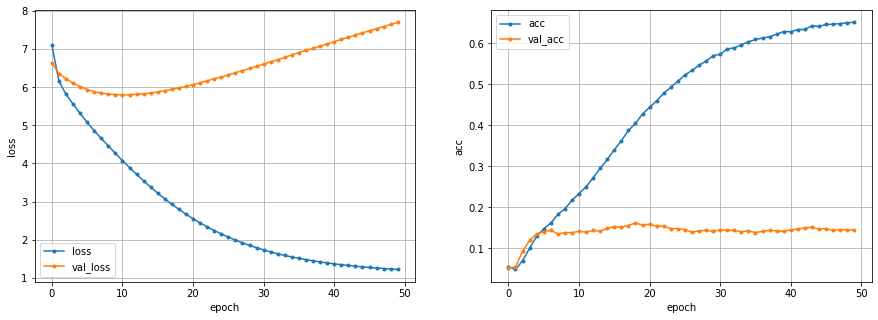

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(max_epoch), loss, marker='.', label='loss')
plt.plot(range(max_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(max_epoch), acc, marker='.', label='acc')
plt.plot(range(max_epoch), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [13]:
#重みを保存するファイルを作る
f = open('CBOW_vectors.txt' ,mode='w') 
f.write('{} {}\n'.format(vocab_size-1, hidden_size)) #{}にそれぞれvocab_size-1とhidden_sizeが書き込まれる。
#open()の引数modeを'w'とすると書き込み用としてファイルが開かれる。
#ファイルが存在しなければ新規作成、存在していれば上書き（既存の内容は削除）で保存される。

9

In [14]:
vectors = model.get_weights()[0] #入力層と中間層の間の重みの取得
for word, i in tokenizer.word_index.items(): 
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

#tokenizer.word_index.items()は単語と単語IDのdictionary
#str_vecは各word毎の重みベクトル<--これと単語をセットにして.txtファイルとして保存

In [15]:
#tokenizer.word_index.items()の中身を見る
tokenizer.word_index.items()

dict_items([('the', 1), ('and', 2), ('to', 3), ('she', 4), ('a', 5), ('”', 6), ('it', 7), ('of', 8), ('was', 9), ('i', 10), ('in', 11), ('alice', 12), ('her', 13), ('that', 14), ('you', 15), ('as', 16), ('said', 17), ('for', 18), ('had', 19), ('little', 20), ('at', 21), ('be', 22), ('this', 23), ('all', 24), ('with', 25), ('on', 26), ('down', 27), ('very', 28), ('out', 29), ('but', 30), ('not', 31), ('so', 32), ('herself', 33), ('is', 34), ('up', 35), ('me', 36), ('about', 37), ('one', 38), ('mouse', 39), ('if', 40), ('do', 41), ('“i', 42), ('no', 43), ('what', 44), ('they', 45), ('thought', 46), ('then', 47), ('like', 48), ('when', 49), ('way', 50), ('again', 51), ('or', 52), ('there', 53), ('rabbit', 54), ('see', 55), ('went', 56), ('know', 57), ('could', 58), ('how', 59), ('time', 60), ('by', 61), ('get', 62), ('into', 63), ('think', 64), ('quite', 65), ('here', 66), ('were', 67), ('would', 68), ('must', 69), ('them', 70), ('my', 71), ('i’m', 72), ('thing', 73), ('have', 74), ('dear

In [16]:
# gensimを使って学習したCBOWの重み(単語の分散表現)を取り出す
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format('./CBOW_vectors.txt', binary=False)

In [17]:
# 入力した単語と近いベクトルを列挙する
word2vec.most_similar(positive=['he'])

[('won', 0.5381280779838562),
 ('happens', 0.4906991124153137),
 ('“do', 0.47640135884284973),
 ('master', 0.4704367518424988),
 ('“nobody', 0.4472370147705078),
 ('she', 0.44414377212524414),
 ('severely', 0.41007447242736816),
 ('jaws', 0.3871568441390991),
 ('paused', 0.382528156042099),
 ('case', 0.3716166019439697)]

#### おまけ

gensimを使うとwikipediaを学習済みの公開モデルを使うことができます。

(参考)　http://kento1109.hatenablog.com/entry/2017/11/15/230004

In [18]:
#演習の授業用にdropboxにアップロードしておきましたので、そこからデータセットをダウンロードします
import urllib.request 

url = "https://www.dropbox.com/s/y0xrkcv9iwomljh/entity_vector.zip?dl=1" # 保存したいファイルのURLを指定 (dropboxのURLを指定する際は、最後のdl=0をdl=1に設定する)
save_name = "entity_vector.zip" # entity_vector.zipという名前で保存される。
 
# ダウンロードを実行
urllib.request.urlretrieve(url, save_name)

('entity_vector.zip', <http.client.HTTPMessage at 0x7fc5f0193ac8>)

In [19]:
#uploadしたzipファイルを解凍する
import zipfile
with zipfile.ZipFile("entity_vector.zip","r") as zip_ref:
    zip_ref.extractall("") #""の中にはディレクトリのpathが入る

In [20]:
from gensim.models import KeyedVectors
model_dir = 'entity_vector/entity_vector.model.bin'
model = KeyedVectors.load_word2vec_format(model_dir, binary=True)
similar_rugby_list = model.most_similar(u'[ラグビー]')
for similar_set in similar_rugby_list:
    print (similar_set[0])
    print (similar_set[1])

ラグビー
0.7684316635131836
[サッカー]
0.7571812868118286
[アイスホッケー]
0.7198296785354614
[ハンドボール]
0.7171785831451416
[バレーボール]
0.7139065265655518
[バスケットボール]
0.7011639475822449
[女子野球]
0.6983809471130371
[ソフトボール]
0.6887843608856201
サッカー
0.6880794167518616
[水球]
0.6868013143539429


In [21]:
from gensim.models import KeyedVectors
model_dir = 'entity_vector/entity_vector.model.bin'
model = KeyedVectors.load_word2vec_format(model_dir, binary=True)
similar_rugby_list = model.most_similar(positive=[u'[新宿]',u'[大阪府]'],negative=[u'[東京都]'])
for similar_set in similar_rugby_list:
    print (similar_set[0])
    print (similar_set[1])

[梅田]
0.6829696893692017
[ミナミ]
0.6623619794845581
[日本橋_(大阪市)]
0.6565461158752441
[心斎橋]
0.655109167098999
[千日前]
0.6459918022155762
[難波]
0.6324417591094971
阿倍野
0.6287933588027954
[新世界_(大阪)]
0.6217558979988098
[北新地]
0.6190609335899353
[キタ]
0.6080436706542969
